In [33]:
import cv2                                # Image processing
from matplotlib import pyplot as plt      # Plotting
import numpy as np                        # Maths
import imutils                            # Image processing
import copy                               # Deepcopy function
import tifffile                           # Reading tif images

import warnings
warnings.filterwarnings("ignore")         # Remove unnecessary pyplot warnings

In [73]:
def read_tif(fpath):
    """ Read FEI SEM .tif image from filepath
    Return image with scalebar cropped, pixel width, 
    image width, and image height in metres"""
    # Get image scale from metadata
    im_file = tifffile.TiffFile(fpath)
    px = im_file.fei_metadata['Scan']['PixelWidth']
    w = im_file.fei_metadata['EBeam']['HFW']
    h = im_file.fei_metadata['EBeam']['VFW']
    
    # Open image and crop out scale bar
    im = cv2.imread(fpath)
    lim = int(np.floor(h/px))
    im_crop = im[:lim,:]
    
    return im_crop, im, px, w, h

def get_contours(binary):
    try:
        contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    except:
        contours, hierarchy = cv2.findContours(binary,cv2.RETR_FLOODFILL,cv2.CHAIN_APPROX_SIMPLE)
    big_cnt = []

    for c in contours:
        area = cv2.contourArea(c)
        perim = cv2.arcLength(c,True)
        if area > 3000 or perim > 2000:
            big_cnt.append(c)
#         if np.shape(c)[0] > 150:
#             big_cnt.append(c)

    return big_cnt

def plot_contours(cnts,im):
    cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for i in range(len(cnts)):
        plt.scatter(cnts[i][:,0][:][:,0],cnts[i][:,0][:][:,1],s=2,color=cols[i%len(cols)],alpha=0.4)
        plt.imshow(im,cmap='gray')

def extract_contours(im, method = 'blur_fill',plot=False):

    if method == 'blur_fill':
        # Filter 1: im -> Gray -> Blur -> Threshold -> Open
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
        kernel = np.ones((5,5),np.uint8)
        opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel)
        cnts = get_contours(opening)
        pic = opening
    
    if method == 'sobel':
        # Filter 2: im -> Gray -> Sobel -> Threshold
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=11)
        sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=11)
        sobel = abs(sobelx) + abs(sobely)

        x = np.clip(sobel,0,.4e7)
        x = x/np.max(x)*255
        x = cv2.GaussianBlur(x, (3, 3), 0)
        thresh = cv2.threshold(x, 60, 255, cv2.THRESH_BINARY)[1]
        thresh = thresh.astype(np.uint8)
        kernel = np.ones((3,3),np.uint8)
        opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel)
        cnts = get_contours(opening)
        pic = thresh
        
    if plot == True:
        plot_contours(cnts,pic)
        
    return cnts

def detect_shapes(cs):
    shapes = []
    for c in cs:
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.01 * peri, True)
        shapes.append(approx)
    
    return shapes

def plot_shapes(shapes,im):
    cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for i,s in enumerate(shapes):
        x1,x2 = s[:][0,0][0],s[:][-1,0][0]
        y1,y2 = s[:][0,0][1],s[:][-1,0][1]
        plt.plot(s[:,0][:][:,0],s[:,0][:][:,1],'o-',color=cols[i%len(cols)],alpha=.6)
        plt.plot([x1,x2],[y1,y2],'o-',color=cols[i%len(cols)],alpha=.6,label=None)

    plt.imshow(im)
    
def fit_circles(cnts):
    centres = []
    radii = []

    for c in cnts:
        circle = cv2.minEnclosingCircle(c)
        centres.append(circle[0])
        radii.append(circle[1])
    
    return centres, radii

def calibrate_radii(radii,px):
    ds = []
    for r in radii:
        d = r * px /(1e-9) * 2
        ds.append(d)
    return ds

def plot_circles(im,cnts,centres,radii, ds):
    fig, ax = plt.subplots(figsize=(10,14))
    plot_shapes(cnts,im)
    cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    for i in range(len(cnts)):
        circle1 = plt.Circle(centres[i], radii[i],ec=cols[i%len(cols)],fc=(0,0,0,0),lw=2,ls=':')
        ax.add_patch(circle1)

    d_str = []
    for d in ds:
        d_str.append('%.1f nm' % d)
        d_str.append('_nolegend_')
        
    plt.legend(d_str,title='Diameters',bbox_to_anchor=(1.01, .6))
    
def remove_identical_shapes(all_s,threshold=0.3):
    cents,rads = fit_circles(all_s)

    areas = []
    perims = []
    for s in all_s:
        area = cv2.contourArea(s)
        perim = cv2.arcLength(s,True)
        areas.append(area)
        perims.append(perim)

    to_remove = []
    for i in range(len(all_s)):
        c1,r1,a1,p1 = cents[i],rads[i],areas[i],perims[i]
        for j in range(len(all_s)):
            if j>=i:
                c2,r2,a2,p2 = cents[j],rads[j],areas[j],perims[j]
                tl = 1-threshold
                tu = 1+threshold
                if i != j:
                    if tl < abs(c2[0]/c1[0]) < tu:
                        if tl < abs(c2[1]/c1[1]) < tu:
                            if tl < abs(r2/r1) < tu:
                                if tl < abs(a2/a1) < tu:
                                    if tl < abs(p2/p1) < tu:
                                        to_remove.append(j)
    new_all_s = np.delete(all_s,to_remove)

    return new_all_s

In [3]:
# Get filepath
folder = r'C:\Users\grl31\Dropbox (Cambridge University)\Elizabeth & George\Size counting\LN-010'
filename = r'LN-010_004.tif'
fpath = folder + '\\' + filename

6.97501e-10 pixels per nm, 	 2142.72 nm height 	 1428.48 nm height


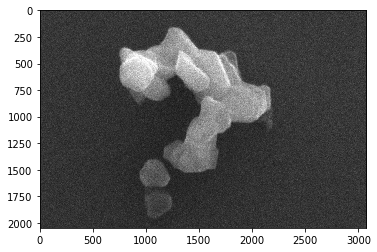

In [4]:
# Read, calibrate, and view image
im,raw_im,px,w,h = read_tif(fpath)
plt.imshow(im)
print(px, 'pixels per nm, \t',w/(1e-9), 'nm height \t',h/(1e-9),'nm height')

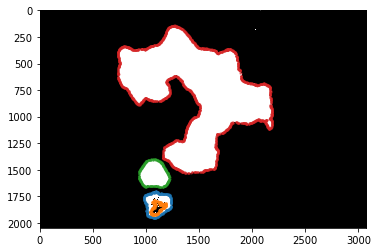

In [16]:
# Extract contours
c1 = extract_contours(im,method='blur_fill',plot=True)

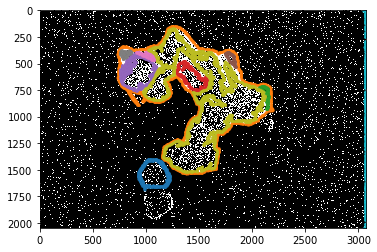

In [17]:
c2 = extract_contours(im,method='sobel',plot=True)

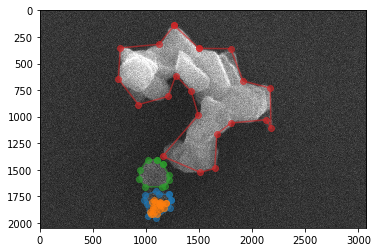

In [18]:
# simplify contours to shapes
s1 = detect_shapes(c1)
plot_shapes(s1,im)

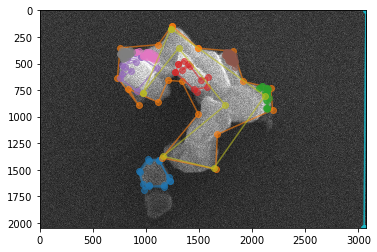

In [19]:
s2 = detect_shapes(c2)
plot_shapes(s2,im)

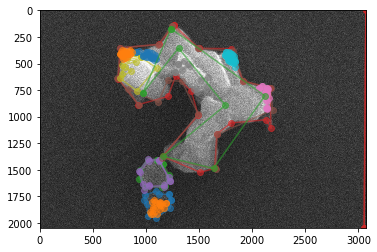

In [69]:
# Merge shapes from different filters together
all_s =np.concatenate((s1,s2))
plot_shapes(all_s,im)

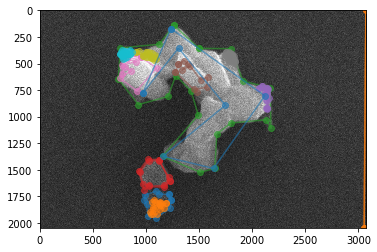

In [74]:
# Remove identical shapes
new_all_s = remove_identical_shapes(all_s,threshold=.3)
plot_shapes(new_all_s,im)

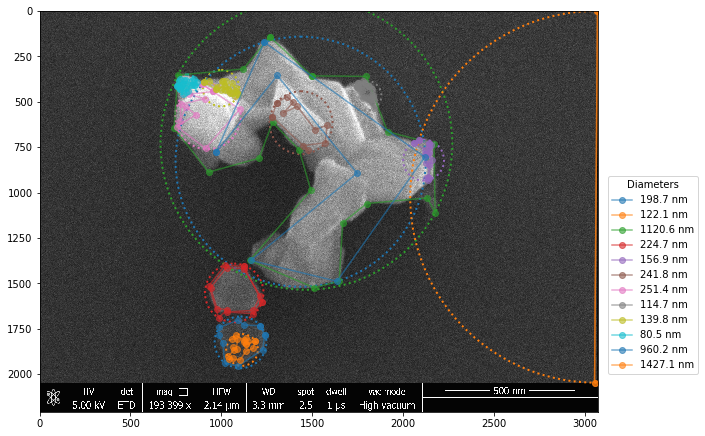

In [72]:
# Plot final measurements
cents,rads = fit_circles(new_all_s)
ds = calibrate_radii(rads,px)
plot_circles(raw_im,new_all_s,cents,rads,ds)